# Studying the Growth Factor

Reference: [Cosmological Perturbation Theory in the Synchronous and Conformal
 Newtonian Gauges](https://arxiv.org/pdf/astro-ph/9506072), by Chung-Pei Ma and Edmund Bertschinger.

The growth of matter perturbations is one of the key theoretical predictions in cosmology and is closely related to many observables, such as cosmic shear, galaxy clustering (and their cross-correlations), and CMB lensing. This project investigates how matter perturbations grow in the linear regime. A simple goal is to reproduce Figure 8.2 from Modern Cosmology ed. 2, by Scott Dodelson and Fabian Schmidt.

<p align="center">
    <img src="dodelson_matter_tk.png" alt="drawing" width="1000"/>
</p>

I will use Mpc units. Assuming $c = 1$, we have $\mathrm{km}/\mathrm{s} = 1/299.792,458$; therefore, $H_0 = 100h/299.792,458 \, \mathrm{Mpc}^{-1}$.

Furthermore, **all densities will be given with a factor of $8\pi G$, *i.e.* all densities you encounter in the code are actually $8\pi G \rho$, and their units are $\mathrm{Mpc}^{-2}$.** The densities only enter the cosmological equations accompanied by this factor. Furthermore, $8\pi G \rho_\mathrm{cr} = 3H_0^2$.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
from scipy.optimize import root_scalar

In [23]:
# Constants
c_in_km_s = 299_792.458

# Free and derived parameters
h = 0.7
H0 = 100*h/c_in_km_s # 1/Mpc
rho_crit = 3*H0**2 # 1/Mpc^2
Omega_m = 0.3
Omega_r = 2.5e-5
Omega_Lambda = 1 - Omega_m - Omega_r
a_eq = Omega_r/Omega_m
w_gamma = 1/3
w_m = 0
w_Lambda = -1

# Densities (8*\pi*G*\rho)
def rho_m(a):
    return rho_crit*Omega_m*a**-3

def rho_gamma(a):
    return rho_crit*Omega_r*a**-4

def rho_lambda(a):
    return rho_crit*Omega_Lambda

def rho_tot(a):
    return rho_crit*(Omega_r*a**-4 + Omega_m*a**-3 + Omega_Lambda)

def P(a):
    return rho_crit*(w_gamma*Omega_r*a**-4 + w_m*Omega_m*a**-3 + w_Lambda*Omega_Lambda)

def H_curly(a):
    return a*np.sqrt(rho_tot(a)/3)

def scale_factor_horizon_entry(k):
    # Find the value of `a` such that k = H_curly
    return np.exp(root_scalar(lambda loga: H_curly(np.exp(loga)) - k, x0=-15).root)

# Derivative of the system with respect to scale factor
def dy_da(y, a, k=0.1):
    delta_m, theta_m, delta_gamma, theta_gamma, Phi = y
    H = H_curly(a)
    rho_m_now = rho_m(a)
    rho_gamma_now = rho_gamma(a)
    sigma_gamma = 0 # TODO: implement anisotropic stress, for now it's zero
    Phi_prime   = -H*Phi + 0.5*a**2*rho_m_now*theta_m/k**2 + 0.5*a**2*(1 + w_gamma)*rho_gamma_now*theta_gamma/k**2
    delta_m_prime = -theta_m + 3*Phi_prime
    theta_m_prime = -H*theta_m + k**2 * Phi
    delta_gamma_prime = -4*theta_gamma/3 + 4*Phi_prime
    theta_gamma_prime = k**2*(delta_gamma/4 - sigma_gamma) + k**2 * Phi
    return np.array([delta_m_prime, theta_m_prime, delta_gamma_prime, theta_gamma_prime, Phi_prime])/(a*H)

def dy_dloga(y, loga, k=0.1):
    a = np.exp(loga)
    deriv = dy_da(y, a, k)
    return a*deriv

def integrate(k):
    # Initial conditions
    tau_ini = 3e-4
    a_ini = H0*np.sqrt(Omega_r)*tau_ini + H0**2*Omega_m*tau_ini**2/4
    C = 1 # Arbitrary scale of adiabatic initial conditions
    Phi_ini = 4/3*C # Primordial curvature perturbation
    delta_gamma_ini = -2*Phi_ini
    theta_gamma_ini = 0.5*k**2*tau_ini*Phi_ini
    delta_c_ini = 3*delta_gamma_ini/4
    theta_c_ini = theta_gamma_ini
    y0 = [delta_c_ini, theta_c_ini, delta_gamma_ini, theta_gamma_ini, Phi_ini]

    # Defining scale factor grid for integration
    loga_int = np.linspace(np.log(a_ini), np.log(1), 4000)
    a = np.exp(loga_int)
    result = odeint(dy_dloga, y0, t=loga_int, args=(k,))
    return a, result

def solve_system_for_ks(ks):
    results = []
    for k in ks:
        a, result = integrate(k)
        results.append(result)
    return a, results

## The Matter Transfer Function
The numerical evolution of the matter perturbation Fourier modes is called the matter transfer function.

In [ ]:
ks = [0.001, 0.01, 0.1, 2]
a, results = solve_system_for_ks(ks)

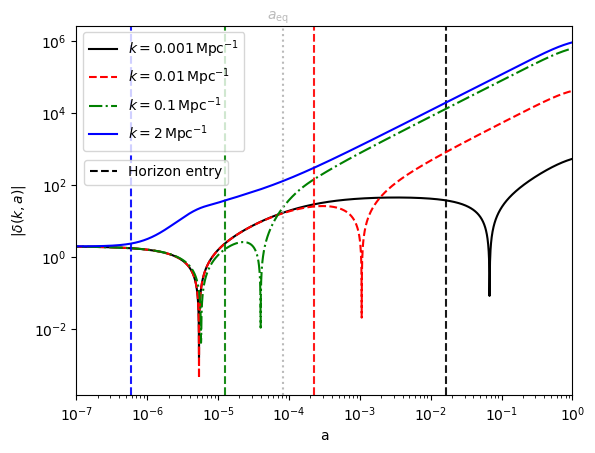

In [ ]:
# From https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=6
styles = [
    ("black", "-"),
    ("red", "--"),
    ("green", "-."),
    ("blue", "-"),
]

fig, ax = plt.subplots()
for k, result, (color, ls) in zip(ks, results, styles):
    delta_m, theta_m, delta_gamma, theta_gamma, Phi = result.T
    ax.loglog(a, np.abs(delta_m), label=f"$k = {k} \\, \\mathrm{{Mpc}}^{{-1}}$", color=color, ls=ls)
    a_horizon_entry = scale_factor_horizon_entry(k)
    ax.axvline(a_horizon_entry, alpha=0.9, ls="--", color=color)


ax.axvline(a_eq, c="darkgray", alpha=0.8, ls=":")
ax.text(a_eq/1.7, 4e6, r"$a_\mathrm{eq}$", c="darkgray", alpha=0.8)

ax.set_xlim([1e-7, 1])
ax.set_xlabel("a")
ax.set_ylabel(r"$|\delta(k, a)|$")
ax.legend()

line = matplotlib.lines.Line2D([], [], color='black', ls="--", label='Horizon entry')
legend = ax.legend()
ax.add_artist(legend)
ax.legend(handles=[line], bbox_to_anchor=(0.32, 0.55))
plt.savefig("deltas.pdf")

An interesting observation: before entering the horizon, all modes follow the same evolution. Also, deep inside the horizon, all lines become parallel, meaning that they also evolve the same in this limit.

## The Matter Power Spectrum

Armed with the transfer functions, we can connect the initial power spectrum to the present-day one:

\begin{equation}
    P(k, a) = \Delta_i(k) \times \frac{2\pi^2}{k^3} \times T^2(k, a),
\end{equation}
where $T(k, a)$ is the matter transfer function (\textit{i.e.} its numerical evolution) and $\Delta_i(k)$ is the initial dimensionless power spectrum,
\begin{equation}
    \Delta_i(k) = A_s\left( \frac{k}{k_p}\right)^{n_s - 1}
\end{equation}

In [ ]:
ks = np.logspace(-3, np.log10(3), 31)
a, results = solve_system_for_ks(ks)

Text(0, 0.5, '$P(k) \\, (\\mathrm{Mpc}^3)$')

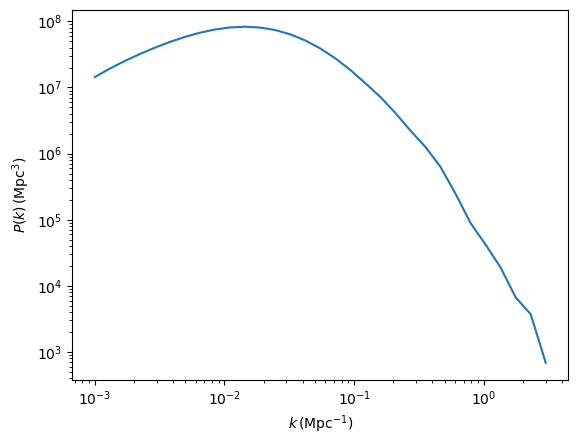

In [25]:
# Collecting power spectra
As = 2.1e-9
ns = 0.96
Pk = []
for result, k in zip(results, ks):
    delta_m, theta_m, delta_gamma, theta_gamma, Phi = result.T
    delta_m_now = delta_m[-1]
    Pk_at_k = As*(k/0.05)**(ns-1) * 2 * np.pi**2 / k**3 * delta_m_now**2
    Pk.append(Pk_at_k)

plt.loglog(ks, Pk)
plt.xlabel(r"$k \, (\mathrm{Mpc}^{-1})$")
plt.ylabel(r"$P(k) \, (\mathrm{Mpc}^3)$")